# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
import multiprocessing as mp
from shapely import Polygon,Point,MultiPolygon,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
from scipy.stats import linregress
from sklearn.cluster import DBSCAN
from scipy.ndimage import gaussian_filter
from shapely.ops import unary_union
from scipy.spatial import Delaunay

source $HOME/miniforge3/bin/activate


### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
      :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))
def alpha_shape(points, alpha=0.1):
    if len(points) < 4:
        return MultiPoint(points).convex_hull

    coords = np.array([[p.x, p.y] for p in points])
    tri = Delaunay(coords)

    triangles = []
    for ia, ib, ic in tri.simplices:
        pa, pb, pc = coords[ia], coords[ib], coords[ic]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < 1.0 / alpha:
            triangle = Polygon([pa, pb, pc])
            triangles.append(triangle)

    return unary_union(triangles)

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [10]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')

wind_file = nc4.Dataset(root / '2022' /'outputs' / 'fort.74.nc')
pressure_file = nc4.Dataset(root / '2022' /'outputs' / 'fort.73.nc')
pfile = root / '2022' /'outputs' / 'fort.73.nc'

In [4]:
start_date = pd.to_datetime("2022-09-08")
end_date = pd.to_datetime("2022-09-20")


In [5]:

times = wind_file.variables['time'][:]

start = pd.to_datetime(wind_file.variables['time'].base_date)
timestamps = pd.date_range(start=start, freq='1h', periods=len(times)).tz_localize(None)
time_mask = (timestamps >= start_date) & (timestamps <= end_date)
timestamps = timestamps[time_mask]
lon = wind_file.variables['x'][:]
lat = wind_file.variables['y'][:]
windx = wind_file.variables['windx'][time_mask,:]
windy = wind_file.variables['windy'][time_mask,:]

# === Compute wind speed ===
wind_speed = np.sqrt(windx**2 + windy**2)  # Shape: [time, node]
pressure = pressure_file.variables['pressure'][time_mask,:]
# === Track cyclone using max wind speed ===

pressure_hpa = pressure * 98.07

In [32]:
def detect_local_minima(timestamps, pressure_hpa, wind_speed, lat, lon):
    detections = []
    for i, t in enumerate(timestamps):
        p = pressure_hpa[i, :]
        w = wind_speed[i, :]
        smoothed_p = gaussian_filter(p, sigma=2)
        local_min_indices = np.argpartition(smoothed_p, 3)[:3]
        for idx in local_min_indices:
            if 930 < smoothed_p[idx] < 1040 and w[idx] > 4:
                detections.append({
                    'timestamp': t,
                    'lat': lat[idx],
                    'lon': lon[idx],
                    'wind_speed': w[idx],
                    'pressure': smoothed_p[idx]
                })
    return detections

def filter_by_domain(detections, lon, lat, pressure_file):
    from shapely.geometry import MultiPolygon
    try:
        with nc4.Dataset(pressure_file) as ds:
            elements = ds.variables['element'][:] - 1
            zeta = ds.variables['pressure'][:]
            max_zeta = np.max(zeta, axis=0)
            if np.ma.is_masked(max_zeta):
                masked_nodes = np.where(max_zeta.mask)[0]
                tri_mask = np.any(np.isin(elements, masked_nodes), axis=1)
                elements = elements[~tri_mask]  # remove masked triangles

        triangles = []
        for tri in elements:
            coords = [(lon[tri[0]], lat[tri[0]]), (lon[tri[1]], lat[tri[1]]), (lon[tri[2]], lat[tri[2]])]
            triangles.append(Polygon(coords))
        domain_polygon = unary_union(triangles)
    except Exception as e:
        print("Could not build domain polygon from elements:", e)
        node_points = [Point(lon[i], lat[i]) for i in range(len(lon))]
        domain_polygon = alpha_shape(node_points, alpha=0.02)

    df = pd.DataFrame(detections)
    df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    return gdf[gdf.geometry.within(domain_polygon)].copy()


def run_dbscan(df):
    from uuid import uuid4
    from sklearn.cluster import DBSCAN

    lat_km = 111
    lon_km = 55
    df['lat_km'] = df['lat'] * lat_km
    df['lon_km'] = df['lon'] * lon_km
    df['time_numeric'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600.0
    scaled_coords = df[['lat_km', 'lon_km', 'time_numeric']].to_numpy()

    db = DBSCAN(eps=150, min_samples=3).fit(scaled_coords)
    df['track_number'] = db.labels_

    track_durations = df.groupby('track_number')['timestamp'].agg(['min', 'max'])
    track_durations['duration_hours'] = (track_durations['max'] - track_durations['min']).dt.total_seconds() / 3600.0
    valid_tracks = track_durations[track_durations['duration_hours'] >= 24].index

    df = df[df['track_number'].isin(valid_tracks)].copy()

    cluster_to_uid = {label: str(uuid4()) for label in df['track_number'].unique() if label != -1}
    df['track_id'] = df['track_number'].apply(lambda x: cluster_to_uid.get(x, 'noise'))

    track_durations = df.groupby('track_id')['timestamp'].agg(['min', 'max'])
    track_durations['duration_hours'] = (track_durations['max'] - track_durations['min']).dt.total_seconds() / 3600.0
    valid_tracks = track_durations[track_durations['duration_hours'] >= 24].index

    return df[df['track_id'].isin(valid_tracks)].copy()
def closest_track_to_merbok(df):
    # Identify Merbok as the only track that crosses the Bering Strait (~66.5N)
    for track_id, group in df[df['track_id'] != 'noise'].groupby('track_id'):
        if group['lat'].max() >= 66.5:
            return track_id
    print("Warning: No track crosses the Bering Strait. Merbok not found.")
    return -999

In [33]:
detections = detect_local_minima(timestamps, pressure_hpa, wind_speed, lat, lon)
df = filter_by_domain(detections, lon, lat, pfile)
df['time_numeric'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600.0
df = run_dbscan(df)
start_point = np.array([58.25, -170.0])
merbok_id = closest_track_to_merbok(df)
df['track_label'] = df['track_id'].apply(lambda x: 'merbok' if x == merbok_id else ('noise' if x == 'noise' else 'other'))


In [34]:
df['datetime'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
gdf.to_file("/scratch/tmiesse/project/tracks/cyclone_merbok_track_2022_filtered.shp")

In [6]:
detections = []
for i, t in enumerate(timestamps):
    p = pressure_hpa[i, :]
    w = wind_speed[i, :]
    smoothed_p = gaussian_filter(p, sigma=2)

    # Get indices of lowest N values (e.g. top 3 minima)
    local_min_indices = np.argpartition(smoothed_p, 3)[:3]

    for idx in local_min_indices:
        if 950 < smoothed_p[idx] < 1010 and w[idx] > 10:
            detections.append({
                'timestamp': t,
                'lat': lat[idx],
                'lon': lon[idx],
                'wind_speed': w[idx],
                'pressure': smoothed_p[idx]
            })
# === Create DataFrame ===
node_points = [Point(lon[i], lat[i]) for i in range(len(lon))]
domain_polygon = alpha_shape(node_points, alpha=0.02)
# Optional: buffer zone (in degrees) to remove detections too close to boundaries



df = pd.DataFrame(detections)
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_detections = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Filter only detections inside domain polygon
gdf_detections = gdf_detections[gdf_detections.geometry.within(domain_polygon)]

df = gdf_detections.copy()
df['time_numeric'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600.0

# === Run DBSCAN on lat/lon/time ===
from uuid import uuid4
# === Normalize time and distance scales for DBSCAN with dynamic radius ===
from sklearn.preprocessing import StandardScaler

# Approximate degree-to-km conversion at 60N
lat_km = 111
lon_km = 55

df['lat_km'] = df['lat'] * lat_km

df['lon_km'] = df['lon'].apply(lambda x: x * lon_km)
scaled_coords = df[['lat_km', 'lon_km', 'time_numeric']].to_numpy()

db = DBSCAN(eps=150, min_samples=3).fit(scaled_coords)  # eps in km + hours
df['track_number'] = db.labels_
# Assign unique string identifiers AFTER filtering
from collections import defaultdict

# Filter tracks by duration (minimum 24 hours)
track_durations = df.groupby('track_number')['timestamp'].agg(['min', 'max'])
track_durations['duration_hours'] = (track_durations['max'] - track_durations['min']).dt.total_seconds() / 3600.0
valid_tracks = track_durations[track_durations['duration_hours'] >= 24].index

df = df[df['track_number'].isin(valid_tracks)].copy()

# Assign new UUIDs only to valid tracks
cluster_to_uid = {label: str(uuid4()) for label in df['track_number'].unique() if label != -1}
df['track_id'] = df['track_number'].apply(lambda x: cluster_to_uid.get(x, 'noise'))

# === Filter tracks by duration (minimum 24 hours) ===
track_durations = df.groupby('track_id')['timestamp'].agg(['min', 'max'])
track_durations['duration_hours'] = (track_durations['max'] - track_durations['min']).dt.total_seconds() / 3600.0
valid_tracks = track_durations[track_durations['duration_hours'] >= 24].index

df = df[df['track_id'].isin(valid_tracks)].copy()

# === Identify Merbok by known start location ===
start_point = np.array([58.25, -170.0])

def closest_track_to_merbok(df):
    # Identify Merbok as the only track that crosses the Bering Strait (~66.5N)
    for track_id, group in df[df['track_id'] != 'noise'].groupby('track_id'):
        if group['lat'].max() >= 66.5:
            return track_id
    print("Warning: No track crosses the Bering Strait. Merbok not found.")
    return -999

merbok_id = closest_track_to_merbok(df)
df['track_label'] = df['track_id'].apply(lambda x: 'merbok' if x == merbok_id else ('noise' if x == 'noise' else 'other'))


In [7]:
df['datetime'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
gdf.to_file("/scratch/tmiesse/project/tracks/cyclone_merbok_track_2022_filtered.shp")
print("Saved shapefile as cyclone_merbok_track_2022_filtered.shp")

Saved shapefile as cyclone_merbok_track_2022_filtered.shp


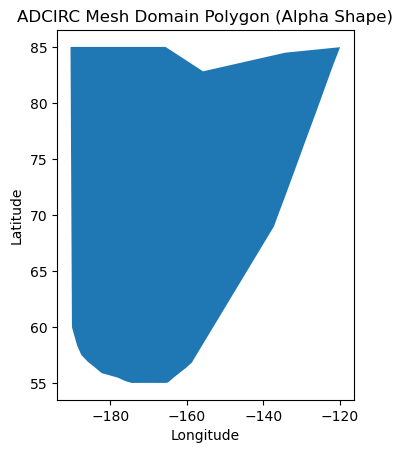

In [9]:
# === Build alpha shape ===
node_points = [Point(lon[i], lat[i]) for i in range(len(lon))]

def alpha_shape(points, alpha=0.02):
    if len(points) < 4:
        return MultiPoint(points).convex_hull
    coords = np.array([[p.x, p.y] for p in points])
    tri = Delaunay(coords)
    triangles = []
    for ia, ib, ic in tri.simplices:
        pa, pb, pc = coords[ia], coords[ib], coords[ic]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < 1.0 / alpha:
            triangles.append(Polygon([pa, pb, pc]))
    return unary_union(triangles)

domain_polygon = alpha_shape(node_points, alpha=0.02)

# === Plot the result ===
gdf = gpd.GeoDataFrame(geometry=[domain_polygon], crs="EPSG:4326")
gdf.plot()
plt.title("ADCIRC Mesh Domain Polygon (Alpha Shape)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()